In [1]:
import trainer
from utils import get_batch_classifier, slanted_triangular_learning_rate
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
%matplotlib inline

In [2]:
VERSION = '107_intent'
with open(VERSION+'/word2idx.json', 'r') as inp:
    word2idx = json.load(inp)
with open(VERSION+'/char2idx.json', 'r') as inp:
    char2idx = json.load(inp)

In [3]:
with open(VERSION+'/trainer_params.json', 'r') as inp:
    params = json.load(inp)
    
my_trainer = trainer.Trainer(**params, fine_tune=True)

my_trainer.logger.info('Trainer params {}'.format(params))

tf.reset_default_graph()

Trainer params {'model_configs': {'drop_e': 0.1, 'skip_connection': True, 'projection_dims': 512, 'char_cnn_options': {'n_highways': 2, 'layers': [[1, 16], [2, 16], [3, 32], [4, 64], [5, 128], [6, 256], [7, 512]]}, 'char_vocab_size': 1088, 'vocab_size': 125409, 'rnn_layers': [{'drop_o': 0.2, 'drop_i': 0.2, 'units': 1024, 'wdrop': 0.4}, {'drop_o': 0.2, 'units': 1024, 'wdrop': 0.4}, {'drop_o': 0.2, 'units': 1024, 'wdrop': 0.4}], 'char_vec_size': 16}, 'bptt': 100, 'optimizer': {'params': {'weight_decay': 1.2e-06, 'beta2': 0.99, 'beta1': 0.8}, 'name': 'adamw'}, 'train_summary_dir': '107_intent/train_summary/', 'negative_samples': 10000, 'wdecay': 0.0, 'checkpoint_dir': '107_intent/checkpoints/', 'log_path': '107_intent/logs', 'beta': 1e-06, 'use_ema': True, 'test_summary_dir': '107_intent/test_summary/', 'clip_norm': 0.3, 'save_freq': 1000, 'alpha': 1e-06}


In [4]:
classifier_configs = {
    'layers': [
        {'batch_norm': False, 'drop_out': 0.2},
        {'units': 50, 'batch_norm': False, 'drop_out': 0.1, 'activation': 'relu'}
    ], 'n_classes': 2
}
my_trainer.build_classifier(classifier_configs, folder_name='interest_train', save_optimizer_var=False)

In [5]:
my_trainer.restore_language_model('107_intent/checkpoints/fine_tune_test/model-full.cpkt-81219')

INFO:tensorflow:Restoring parameters from 107_intent/checkpoints/fine_tune_test/model-full.cpkt-81219


Restoring parameters from 107_intent/checkpoints/fine_tune_test/model-full.cpkt-81219


In [6]:
class_chars = np.load('IntentDetection/full/class_chars.npy')
class_labels = pd.read_csv('IntentDetection/full/class_label.csv')

In [7]:
positive = class_chars[class_labels['interest']==1]
negative = class_chars[class_labels['interest']==0]

In [8]:
train_chars = np.concatenate([positive[:50], negative[:50]], axis=0)
train_labels = np.array([1]*50+[0]*50)
test_chars = np.concatenate([positive[50:], negative[50:]], axis=0)
test_labels = np.array([1]*len(positive[50:])+[0]*len(negative[50:]))

In [9]:
TRAIN_FOLDER = 'interest_train'
TEST_FOLDER = 'interest_test'
RATIO = 1/2.6
RATIO1 = RATIO/(1+RATIO)

In [10]:
log_lrs, losses = my_trainer.find_lr_classifier(train_chars, train_labels, 10, 48, [0, 50, 200], init_lr=1e-6, final_lr=1.0, fine_tune_rate=[RATIO,0,0,0])

Batch    1,  lr 0.00000, loss 1.28695, smoothed loss 1.28695
Batch    2,  lr 0.00000, loss 1.34559, smoothed loss 1.31656
Batch    3,  lr 0.00002, loss 1.92772, smoothed loss 1.52441
Batch    4,  lr 0.00006, loss 1.05175, smoothed loss 1.40264
Batch    5,  lr 0.00025, loss 0.73265, smoothed loss 1.26317
Batch    6,  lr 0.00100, loss 0.71026, smoothed loss 1.16630
Batch    7,  lr 0.00398, loss 1.49412, smoothed loss 1.21602
Batch    8,  lr 0.01585, loss 3.89698, smoothed loss 1.57531
Batch    9,  lr 0.06310, loss 1.24476, smoothed loss 1.53554
Batch   10,  lr 0.25119, loss 4.11440, smoothed loss 1.81750
INFO:tensorflow:Restoring parameters from 107_intent/checkpoints/tmp/model.cpkt


Restoring parameters from 107_intent/checkpoints/tmp/model.cpkt


update_title_pos
findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/root/anaconda2/envs/tfp/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
update_title_pos
update_title_pos
update_title_pos
update_title_pos


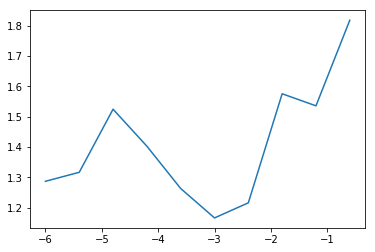

In [11]:
fig = plt.figure()
ax = plt.axes()
ax.plot(log_lrs, losses)

In [12]:
# for _ in range(10):
#     my_trainer.train_step_classifier(train_chars, train_labels, 6, 3e-4, 20, [0, 50, 200], fine_tune_rate=[0, 0, 0, 0], folder_name=TRAIN_FOLDER)

In [13]:
# for _ in range(10):
#     my_trainer.train_step_classifier(train_chars, train_labels, 10, 3e-4, 20, [0, 50, 200], fine_tune_rate=[RATIO, 0, 0, 0], folder_name=TRAIN_FOLDER)

In [14]:
# for _ in range(10):
#     my_trainer.train_step_classifier(train_chars, train_labels, 10, 3e-4, 20, [0, 50, 200], fine_tune_rate=[RATIO, RATIO*RATIO, 0, 0], folder_name=TRAIN_FOLDER)

In [15]:
# for _ in range(10):
#     my_trainer.train_step_classifier(train_chars, train_labels, 10, 3e-4, 20, [0, 50, 200], fine_tune_rate=[RATIO, RATIO*RATIO, RATIO*RATIO*RATIO, 0], folder_name=TRAIN_FOLDER)

In [16]:
# for _ in range(10):
# my_trainer.train_step_classifier(train_chars, train_labels, 6, 3e-4, 20, [0, 50, 200], fine_tune_rate=[1/2.6, 1/2.6, 1/2.6, 1/2.6], folder_name='class_train_180')

In [17]:
NUM_EPOCH = 15
BATCH_SIZE = 10
TOTAL_ITER = NUM_EPOCH * len(train_labels)/BATCH_SIZE
LR_MAX = 1e-3
LR_RATIO = 32

In [18]:
lr = slanted_triangular_learning_rate(TOTAL_ITER, 1/NUM_EPOCH, LR_MAX, LR_RATIO)
for _ in range(NUM_EPOCH):
    my_trainer.train_step_classifier(train_chars, train_labels, BATCH_SIZE, lr, 48, [0, 50, 200], fine_tune_rate=[RATIO, RATIO1, RATIO1, RATIO], folder_name=TRAIN_FOLDER)
#     lr = max(lr * 0.4, 1e-5)

Step    1: loss: 0.88038, acc: 0.70000, bptt:  52, time 03.86
Step    2: loss: 1.01360, acc: 0.60000, bptt:  40, time 03.98
Step    3: loss: 0.90978, acc: 0.70000, bptt:  44, time 04.17
Step    4: loss: 0.86955, acc: 0.50000, bptt:  44, time 04.32
Step    5: loss: 0.68284, acc: 0.60000, bptt:  46, time 04.44
Step    6: loss: 0.58446, acc: 0.70000, bptt:  45, time 04.58
Step    7: loss: 0.79076, acc: 0.50000, bptt:  48, time 04.76
Step    8: loss: 0.57848, acc: 0.70000, bptt:  47, time 04.89
Step    9: loss: 0.66445, acc: 0.60000, bptt:  23, time 05.07
Step   10: loss: 0.71952, acc: 0.40000, bptt:  42, time 05.37
Step   11: loss: 0.47029, acc: 0.90000, bptt:  50, time 00.21
Step   12: loss: 0.43925, acc: 0.90000, bptt:  50, time 00.37
Step   13: loss: 0.70450, acc: 0.30000, bptt:  55, time 00.54
Step   14: loss: 0.54110, acc: 0.80000, bptt:  41, time 00.73
Step   15: loss: 0.47494, acc: 0.70000, bptt:  44, time 00.98
Step   16: loss: 0.89166, acc: 0.50000, bptt:  47, time 01.11
Step   1

Ignoring: 107_intent/checkpoints/tmp; No such file or directory
Step   21: loss: 0.25397, acc: 0.90000, bptt:  51, time 00.29
Step   22: loss: 0.75978, acc: 0.50000, bptt:  43, time 00.42
Step   23: loss: 0.23953, acc: 0.90000, bptt:  42, time 00.56
Step   24: loss: 0.10402, acc: 1.00000, bptt:  43, time 00.68
Step   25: loss: 0.46088, acc: 0.70000, bptt:  39, time 00.81
Step   26: loss: 0.84189, acc: 0.70000, bptt:  40, time 01.04
Step   27: loss: 0.54839, acc: 0.70000, bptt:  47, time 01.19
Step   28: loss: 0.31973, acc: 0.80000, bptt:  44, time 01.32
Step   29: loss: 0.12932, acc: 1.00000, bptt:  25, time 01.50
Step   30: loss: 0.31956, acc: 0.80000, bptt:  46, time 01.65
Step   31: loss: 0.09444, acc: 1.00000, bptt:  57, time 00.15
Step   32: loss: 0.18134, acc: 0.90000, bptt:  46, time 00.27
Step   33: loss: 0.03416, acc: 1.00000, bptt:  54, time 00.41
Step   34: loss: 0.02104, acc: 1.00000, bptt:  47, time 00.57
Step   35: loss: 0.06575, acc: 1.00000, bptt:  51, time 00.72
Step  

In [19]:
# for _ in range(10):
#     my_trainer.train_step_classifier(train_chars, train_labels, 12, lr, 20, [0, 50, 200], fine_tune_rate=[1.0, 1.0, 1.0, 1.0], folder_name=TRAIN_FOLDER)
#     lr = max(lr * 0.4, 1e-5)

In [20]:
from sklearn.metrics import classification_report

In [21]:
def eval_step_classifier(self, test_char, test_labels, batch_size, bptt, splits, folder_name='class_test'):
    import time
    import os
    start_time = time.time()
    save_path = os.path.join(self.checkpoint_dir, folder_name, 'model.cpkt')
    self.test_saver.save(self.session, save_path, global_step=self.session.run(self.global_step))
    total_loss = 0
    total_acc = 0
    count = 0
    predicts = []
    y_true = []
    for char_inputs, seq_lens, char_lens, true_labels in get_batch_classifier(test_char, test_labels, batch_size, splits, is_training=False):
        fd = {
            self.model_test.inputs: char_inputs, self.model_test.seq_lens: seq_lens,
            self.model_test.char_lens: char_lens, self.model_test.bptt: bptt,
            self.true_y: true_labels
        }
        y_pred, test_loss, test_acc = self.session.run([self.test_classifier.logits, self.test_loss, self.test_acc], feed_dict=fd)
        total_loss += test_loss * len(true_labels)
        total_acc += test_acc * len(true_labels)
        count += len(true_labels)
        predicts.append(y_pred)
        y_true.append(true_labels)
        print("Evaluate total loss: {:05.5f}, total acc: {:05.5f}, time {:05.2f}".format(total_loss/count, total_acc/count, time.time()-start_time))
    print(count)
    print(total_acc)
    return np.argmax(np.concatenate(predicts), axis=-1), np.concatenate(y_true)

In [22]:
y_pred, y_true = eval_step_classifier(my_trainer, test_chars, test_labels, 10, 20, [0, 50, 200], TEST_FOLDER)

Evaluate total loss: 4.37559, total acc: 0.00000, time 02.05
Evaluate total loss: 3.82343, total acc: 0.00000, time 03.20
Evaluate total loss: 3.52731, total acc: 0.10000, time 04.76
Evaluate total loss: 2.67977, total acc: 0.30000, time 04.94
Evaluate total loss: 2.87605, total acc: 0.30000, time 05.06
Evaluate total loss: 3.16456, total acc: 0.30000, time 05.30
Evaluate total loss: 3.25949, total acc: 0.31429, time 05.42
Evaluate total loss: 3.36150, total acc: 0.32500, time 05.53
Evaluate total loss: 3.52812, total acc: 0.33333, time 05.64
Evaluate total loss: 3.80910, total acc: 0.31000, time 05.81
Evaluate total loss: 3.66692, total acc: 0.34545, time 06.06
Evaluate total loss: 3.77601, total acc: 0.31667, time 06.19
Evaluate total loss: 4.07392, total acc: 0.29231, time 06.31
Evaluate total loss: 4.18646, total acc: 0.30000, time 06.54
Evaluate total loss: 4.15348, total acc: 0.30667, time 06.72
Evaluate total loss: 3.90436, total acc: 0.35000, time 06.79
Evaluate total loss: 3.8

Evaluate total loss: 1.79439, total acc: 0.65652, time 13.18
Evaluate total loss: 1.79177, total acc: 0.65683, time 13.22
Evaluate total loss: 1.79104, total acc: 0.65643, time 13.28
Evaluate total loss: 1.79054, total acc: 0.65745, time 13.32
Evaluate total loss: 1.78080, total acc: 0.65845, time 13.36
Evaluate total loss: 1.78337, total acc: 0.65734, time 13.43
Evaluate total loss: 1.78791, total acc: 0.65694, time 13.49
Evaluate total loss: 1.78681, total acc: 0.65724, time 13.53
Evaluate total loss: 1.78315, total acc: 0.65685, time 13.57
Evaluate total loss: 1.77428, total acc: 0.65782, time 13.62
Evaluate total loss: 1.76767, total acc: 0.65878, time 13.67
Evaluate total loss: 1.77255, total acc: 0.65772, time 13.73
Evaluate total loss: 1.77210, total acc: 0.65933, time 13.79
Evaluate total loss: 1.77511, total acc: 0.65828, time 13.86
Evaluate total loss: 1.76497, total acc: 0.65987, time 13.94
Evaluate total loss: 1.76302, total acc: 0.66013, time 13.97
Evaluate total loss: 1.7

Evaluate total loss: 1.82285, total acc: 0.66036, time 19.61
Evaluate total loss: 1.81932, total acc: 0.66014, time 19.65
Evaluate total loss: 1.81333, total acc: 0.66101, time 19.69
Evaluate total loss: 1.81241, total acc: 0.66043, time 19.76
Evaluate total loss: 1.80629, total acc: 0.66165, time 19.81
Evaluate total loss: 1.79998, total acc: 0.66286, time 19.85
Evaluate total loss: 1.79944, total acc: 0.66299, time 19.90
Evaluate total loss: 1.79647, total acc: 0.66348, time 19.95
Evaluate total loss: 1.80137, total acc: 0.66219, time 20.00
Evaluate total loss: 1.80605, total acc: 0.66127, time 20.04
Evaluate total loss: 1.81581, total acc: 0.66000, time 20.09
Evaluate total loss: 1.82406, total acc: 0.65909, time 20.13
Evaluate total loss: 1.83202, total acc: 0.65819, time 20.17
Evaluate total loss: 1.83161, total acc: 0.65764, time 20.22
Evaluate total loss: 1.83522, total acc: 0.65709, time 20.25
Evaluate total loss: 1.84038, total acc: 0.65621, time 20.29
Evaluate total loss: 1.8

Evaluate total loss: 1.96533, total acc: 0.64275, time 26.09
Evaluate total loss: 1.96641, total acc: 0.64265, time 26.16
Evaluate total loss: 1.96914, total acc: 0.64231, time 26.20
Evaluate total loss: 1.97315, total acc: 0.64149, time 26.24
Evaluate total loss: 1.97325, total acc: 0.64187, time 26.30
Evaluate total loss: 1.97557, total acc: 0.64129, time 26.35
Evaluate total loss: 1.97759, total acc: 0.64119, time 26.38
Evaluate total loss: 1.98117, total acc: 0.64062, time 26.43
Evaluate total loss: 1.98693, total acc: 0.63981, time 26.49
Evaluate total loss: 1.99096, total acc: 0.63924, time 26.54
Evaluate total loss: 1.99168, total acc: 0.63892, time 26.58
Evaluate total loss: 1.99603, total acc: 0.63835, time 26.62
Evaluate total loss: 1.99477, total acc: 0.63803, time 26.66
Evaluate total loss: 2.00412, total acc: 0.63677, time 26.72
Evaluate total loss: 2.00205, total acc: 0.63692, time 26.76
Evaluate total loss: 2.01003, total acc: 0.63566, time 26.80
Evaluate total loss: 2.0

Evaluate total loss: 2.04986, total acc: 0.63060, time 32.44
Evaluate total loss: 2.05338, total acc: 0.63000, time 32.50
Evaluate total loss: 2.05366, total acc: 0.62995, time 32.56
Evaluate total loss: 2.05528, total acc: 0.62971, time 32.61
Evaluate total loss: 2.05553, total acc: 0.62984, time 32.68
Evaluate total loss: 2.05218, total acc: 0.63032, time 32.71
Evaluate total loss: 2.04950, total acc: 0.63063, time 32.76
Evaluate total loss: 2.05273, total acc: 0.63004, time 32.83
Evaluate total loss: 2.05023, total acc: 0.63016, time 32.87
Evaluate total loss: 2.05188, total acc: 0.62993, time 32.93
Evaluate total loss: 2.05142, total acc: 0.62987, time 32.98
Evaluate total loss: 2.05416, total acc: 0.62946, time 33.05
Evaluate total loss: 2.05487, total acc: 0.62888, time 33.12
Evaluate total loss: 2.06232, total acc: 0.62794, time 33.19
Evaluate total loss: 2.06307, total acc: 0.62771, time 33.25
Evaluate total loss: 2.06204, total acc: 0.62784, time 33.31
Evaluate total loss: 2.0

In [23]:
print(classification_report(y_true=y_true, y_pred=y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9502    0.6156    0.7472      5305
           1     0.1985    0.7470    0.3137       676

   micro avg     0.6305    0.6305    0.6305      5981
   macro avg     0.5744    0.6813    0.5304      5981
weighted avg     0.8653    0.6305    0.6982      5981



In [22]:
print(classification_report(y_true=y_true, y_pred=y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9466    0.6415    0.7647      5305
           1     0.2028    0.7160    0.3161       676

   micro avg     0.6499    0.6499    0.6499      5981
   macro avg     0.5747    0.6787    0.5404      5981
weighted avg     0.8625    0.6499    0.7140      5981

